<a href="https://colab.research.google.com/github/PavelNovikov888/PDA_vectorization_text/blob/master/%D0%9A%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0_%D0%BE%D1%82%D0%B7%D1%8B%D0%B2%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Векторизация текстов: практическая работа.
Выполнил: Новиков Павел  

Группа: DSPR-77

In [1]:
!pip install datasets --quiet
# !pip install tokenizers==0.10.0rc1 --quiet
!pip install tokenizers
#!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.17.1
    Uninstalling huggingface-hub-0.17.1:
      Successfully uninstalled huggingface-hub-0.17.1


In [2]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# import numpy as np

import datasets
import tokenizers
from sklearn.metrics import accuracy_score
# import wandb
# from tqdm.auto import tqdm

import matplotlib.pyplot as plt

# Задание:

**IMDB** - это датасет по классификации эмоциональной окраски.   
Нам нужно предсказать положительный ли отзыв к фильму по его тексту.   
Для доступа к нему мы используем библиотеку `datasets`

Тренировочная и тестовая части IMDB достаточно большие - каждая состоит из 25 тысяч примеров.

In [3]:
text_dataset = datasets.load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
type(text_dataset)

datasets.dataset_dict.DatasetDict

In [5]:
text_dataset.shape

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}

In [6]:
text_dataset.column_names

{'train': ['text', 'label'],
 'test': ['text', 'label'],
 'unsupervised': ['text', 'label']}

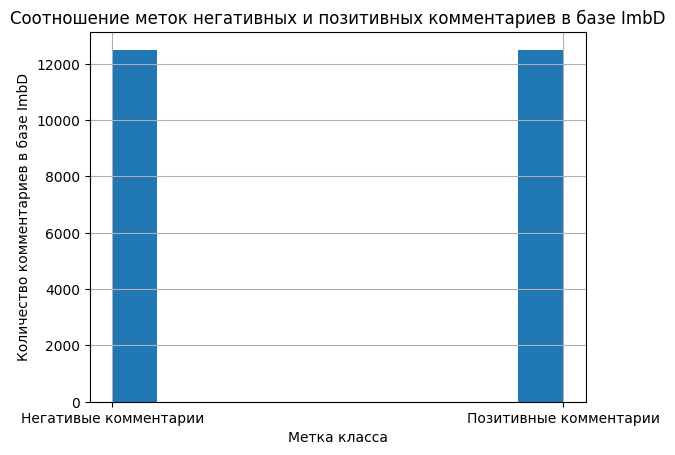

In [7]:
# определим сбалансированность классов
train_labels = [e['label'] for e in text_dataset['train']]
plt.hist(train_labels)
plt.xlabel('Метка класса')
plt.xticks([0,1], ['Негативые комментарии','Позитивные комментарии'])
plt.ylabel('Количество комментариев в базе ImbD')
plt.title('Соотношение меток негативных и позитивных комментариев в базе ImbD')
plt.grid(True)
plt.locator_params (axis='x', nbins= 2 )
plt.show()

Как мы видим, классы сбалансированны, что позволяет использовать accuracy как простую и интерпретируемую метрику, хорошо показывающую качество модели.

# 1. Baseline-модель. Классификация с использованием линейной модели логистической регрессии

Используем библиотеку `sklearn` для создания линейной модели. Для векторизации текста мы будем использовать `TfidfVectorizer`, а в качестве модели `LogisticRegression`.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# создадим и обучим объект векторизации TfidfVectorizer
vectorizer  = TfidfVectorizer()
values = vectorizer.fit(text_dataset['train']['text'])

In [10]:
# 1.конвертируем тексты(обучающий и тестовый) в векторы tf-idf
# 2 конвертируем метки класса в массивы numpy
X_train = values.transform(text_dataset['train']['text'])
y_train = text_dataset['train'].with_format('numpy', columns=['label'])['label']

X_test = values.transform(text_dataset['test']['text'])
y_test = text_dataset['test'].with_format("numpy", columns=['label'])['label']

In [11]:
# создадим и обучим модель логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

А теперь мы используем нашу модель для того, чтобы предсказать классы на тестовых данных и определим метрику accuracy.

In [12]:
predictions = model.predict(X_test)

In [13]:
# определим совпадают ли типы данных для расчета метрики accuracy
print('Совпадают ли типы данных предсказаний и меток тестовых данных: {}'.format(type(predictions) == type(y_test)))
# рассчитаем метрику accuracy
accuracy = (predictions == y_test).mean()
print('Модель Baseline(LogisticRegression()). Значение метрики accuracy: {}'.format(accuracy))

Совпадают ли типы данных предсказаний и меток тестовых данных: True
Модель Baseline(LogisticRegression()). Значение метрики accuracy: 0.88316


С помощью созданной модели логистической регрессии предскажем, позитивны ли следующие комментарии:

In [14]:
positive_comment = 'This movie is awesome!'

vec = vectorizer.transform([positive_comment])
if model.predict(vec)[0] == 1:
  marks = 'Позитивный'
else: marks = 'Негативный'

print('Оцениваемый комментарий: {}'.format(positive_comment))
print('Предсказание оценки комментария: {}.'.format(marks))

Оцениваемый комментарий: This movie is awesome!
Предсказание оценки комментария: Позитивный.


In [15]:
negative_comment = 'This movie is awful!'

vec = vectorizer.transform([negative_comment])
if model.predict(vec)[0] == 1:
  marks = 'Позитивный'
else: marks = 'Негативный'

print('Оцениваемый комментарий: {}'.format(negative_comment))
print('Предсказание оценки комментария: {}.'.format(marks))

Оцениваемый комментарий: This movie is awful!
Предсказание оценки комментария: Негативный.


Вывод: даже такая простая модель может хорошо классифицировать текст.

# 2. Модель линейной регресии LinearSVM
Определим насколько изменится метрика при использовании алгоритма опорных векторов LinearSVM.
Во время использования данного алгоритма определяется гиперплоскость наиболее точно разделяющая признаки и после удаления точек данных, наиболее близко находящихся к гиперплоскости максимизируется точность классификации.

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Модель линейной регрессии LinearSVM()). Значение метрики accuracy: {}'.format(accuracy_score(y_test,y_pred)))

Модель линейной регрессии LinearSVM()). Значение метрики accuracy: 0.88256


# 3. Линейная регрессия LinearRegression() с использованием n-gram в токенизаторе TF-IDF.
Проведем токенизацию текста отзыва с использованием юни- и биграмм.
Для того, чтобы избежать переобучения от большого количества признаков установим параметр `max_features` = 50 000

In [17]:
vectorizer_ngrams  = TfidfVectorizer(ngram_range=(1, 2), max_features = 50000)
values_adv = vectorizer_ngrams.fit(text_dataset['train']['text'])

X_train = values_adv.transform(text_dataset['train']['text'])
y_train = text_dataset['train'].with_format('numpy', columns=['label'])['label']

X_test = values_adv.transform(text_dataset['test']['text'])
y_test = text_dataset['test'].with_format("numpy", columns=['label'])['label']

model_adv = LogisticRegression()
model_adv.fit(X_train, y_train)

predictions = model_adv.predict(X_test)

print('Модель линейной регрессии LinearRegression() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: {}'\
      .format(accuracy_score(y_test, predictions)))

Модель линейной регрессии LinearRegression() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: 0.89436


# 4.Модель линейной регресии LinearSVM с использованием n-gram в токенизаторе TF-IDF.
И, наконец используем сочетание токенизации текста отзыва с использованием юни- и биграмм и метод опорных векторов.
Для того, чтобы избежать переобучения от большого количества признаков установим параметр max_features = 50 000

In [18]:
clf = SVC(kernel='linear')
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Модель линейной регрессии LinearSVM() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: {}'\
      .format(accuracy_score(y_test, y_pred)))

Модель линейной регрессии LinearSVM() c использованием n-грамм в токенизаторе TF-IDF. Значение метрики accuracy: 0.89872


Вывод: Наилучшее качество классификации негативных и положительных отзывов показала модель линейной регресии LinearSVM с использованием n-gram в токенизаторе TF-IDF с показателем метрики accuracy = 0.89872 т.е. примерно в ~90% случаев модель правильно угадала окраску отзыва.  
Выигрыш по сравнению с Baseline составил ~2%